<p align = "center"><strong>GLOBAL SPATIAL AUTOCORRELATION: GEARY I <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Geary’s C Global Bivariate__

__Def.__  

Medida **global de autocorrelación espacial** que cuantifica el grado de **disimilitud espacial** entre los valores de dos variables observadas en unidades espaciales vecinas, de acuerdo con una matriz de pesos espaciales.  
El índice de Geary Bivariado es **más sensible a diferencias locales** que el índice de Moran.

El índice toma los siguientes valores:
- $\to$ __0__ indica fuerte autocorrelación espacial positiva (valores similares),
- $\approx$ __1__ indica ausencia de autocorrelación espacial,
- $\to$ __> 1__ indica autocorrelación espacial negativa (valores disímiles).

__Formula:__

Suma de pesos espaciales:
$$
S_0 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_{ij}
$$

Media y varianza global:
$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i \quad \quad \bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$

Índice bivariado de Geary:
$$
C = \frac{(n-1)}{2S_0} \frac{\sum_{i=1}^{n} \sum_{j=1}^{n} w_{ij} (x_i - y_j)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2 + \sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

<p align='center'> 
<em>El índice global bivariado de Geary evalúa la autocorrelación espacial a partir de las diferencias cuadráticas entre unidades vecinas para dos variables, siendo especialmente sensible a discontinuidades espaciales.</em>
</p>

donde:
- $w_{ij}$: elemento de la matriz de pesos espaciales $W$,
- $x_i$: valor observado de la primera variable de interés en la unidad espacial $i$,
- $y_j$: valor observado de la segunda variable de interés en la unidad espacial contigua (vecina de $x_i$),
- $n$: número de unidades espaciales,
- $\bar{x}$: media global de la primera variable,
- $\bar{y}$: media global de la segunda variable.

__Referencia:__
- Geary, R. C. (1954). *The contiguity ratio and statistical mapping*. The Incorporated Statistician, 5(3), 115–145.  
  https://www.jstor.org/stable/2986645


In [3]:
# DEPENDENCIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from libpysal.weights import Queen, Rook, W, lag_spatial, w_subset
import warnings
import contextlib
from scipy import stats


def global_geary_bv(
    gdf: gpd.GeoDataFrame,
    x_fields,
    y_fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 9999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize_xy: bool = True,
    use_index: bool = True,
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
    dashboard_pair: tuple[str, str] | None = None,
    figsize=(15, 10),
):
    """
    GLOBAL Bivariate Geary's C (implementación manual) para múltiples pares (X,Y) y contigüidades.
    
    El Índice de Geary Bivariado mide la correlación espacial entre dos variables:
    C_xy = (n-1) * sum_i sum_j w_ij * (x_i - x_j) * (y_i - y_j) / (2 * sum_i sum_j w_ij * var_x * var_y)
    
    Scatter: z(X) vs lag(z(Y))
    Hist: distribución de permutaciones para C_xy
    
    Interpretación:
    - C < 1: correlación espacial positiva
    - C ≈ 1: sin correlación espacial
    - C > 1: correlación espacial negativa
    
    Notes:
      - GeoDa usa pesos estandarizados por fila -> w.transform="R"
      - Valor esperado E[C] = 1
    """
    
    # -------------------------
    # BASIC INPUT HANDLING
    # -------------------------
    if isinstance(x_fields, str):
        x_fields = [x_fields]
    if isinstance(y_fields, str):
        y_fields = [y_fields]

    x_fields = list(x_fields)
    y_fields = list(y_fields)

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    # validate columns
    missing = [c for c in set(x_fields + y_fields) if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")

    # build (x,y) pairs with broadcast rules
    if len(x_fields) == len(y_fields):
        pairs = list(zip(x_fields, y_fields))
    elif len(y_fields) == 1:
        pairs = [(x, y_fields[0]) for x in x_fields]
    elif len(x_fields) == 1:
        pairs = [(x_fields[0], y) for y in y_fields]
    else:
        raise ValueError(
            "x_fields and y_fields must have same length, or one of them must have length 1."
        )

    if dashboard_pair is None:
        dashboard_pair = pairs[0]
    if dashboard_pair not in pairs:
        raise ValueError("dashboard_pair must be one of the generated (x,y) pairs")

    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )

    # -------------------------
    # CONTEXT MANAGERS
    # -------------------------
    @contextlib.contextmanager
    def _maybe_style(style_name):
        old = plt.rcParams.copy()
        try:
            plt.style.use(style_name)
            yield
        finally:
            plt.rcParams.update(old)

    @contextlib.contextmanager
    def _maybe_warnings(silence):
        if not silence:
            yield
            return
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=UserWarning,
                message=".*weights matrix is not fully connected.*",
            )
            warnings.filterwarnings(
                "ignore",
                category=FutureWarning,
                message=".*use_index.*",
            )
            yield

    # -------------------------
    # HELPERS
    # -------------------------
    def _zscore(v):
        v = np.asarray(v, dtype=float)
        sd = v.std(ddof=0)
        return (v - v.mean()) / sd if sd > 0 else v * 0.0

    def _build_weights(df):
        wq = Queen.from_dataframe(df, use_index=use_index)
        wr = Rook.from_dataframe(df, use_index=use_index)

        outw = {}
        if "queen" in contiguities:
            outw["queen"] = wq
        if "rook" in contiguities:
            outw["rook"] = wr
        if "bishop" in contiguities:
            ids = list(wq.id_order)
            neighbors = {
                i: list(set(wq.neighbors.get(i, [])) - set(wr.neighbors.get(i, [])))
                for i in ids
            }
            outw["bishop"] = W(neighbors, id_order=ids)

        return outw

    def _subset_drop_islands(w, df):
        ids = list(df.index) if use_index else list(range(len(df)))
        w2 = w_subset(w, ids)

        islands_initial = list(getattr(w2, "islands", []))

        if drop_islands and islands_initial:
            df2 = df.drop(index=islands_initial).copy() if use_index else df.copy()
            ids2 = list(df2.index) if use_index else list(range(len(df2)))
            w2 = w_subset(w, ids2)
            return w2, df2, islands_initial

        return w2, df, islands_initial

    def _safe_float(obj, attr, default=np.nan):
        return float(getattr(obj, attr, default)) if getattr(obj, attr, None) is not None else float(default)
    
    def _bivariate_geary_c(x, y, w):
        """
        Calcula el Índice de Geary Bivariado Global.
        
        Fórmula: 
        C_xy = (n-1) * Σ_i Σ_j w_ij * (x_i - x_j) * (y_i - y_j) / (2 * Σ_i Σ_j w_ij * var_x * var_y)
        
        Para pesos estandarizados por fila, Σ_i Σ_j w_ij = n
        """
        n = len(x)
        
        # Estandarizar variables (opcional, pero recomendado)
        x_std = (x - x.mean()) / x.std(ddof=0) if x.std(ddof=0) > 0 else np.zeros_like(x)
        y_std = (y - y.mean()) / y.std(ddof=0) if y.std(ddof=0) > 0 else np.zeros_like(y)
        
        # Matriz de pesos en formato denso
        w_array = w.full()[0]
        
        # Calcular numerador: Σ_i Σ_j w_ij * (x_i - x_j) * (y_i - y_j)
        numerator = 0
        for i in range(n):
            for j in range(n):
                if i != j:
                    numerator += w_array[i, j] * (x_std[i] - x_std[j]) * (y_std[i] - y_std[j])
        
        # Denominador: 2 * Σ_i Σ_j w_ij * var_x * var_y
        w_sum = w_array.sum()
        denominator = 2 * w_sum * x_std.var(ddof=0) * y_std.var(ddof=0)
        
        if denominator == 0:
            return np.nan
            
        C = (n - 1) * numerator / denominator
        
        return C
    
    def _geary_bv_permutation(x, y, w, permutations=999):
        """
        Implementa prueba de permutaciones para Geary Bivariado.
        """
        n = len(x)
        x_std = (x - x.mean()) / x.std(ddof=0) if x.std(ddof=0) > 0 else np.zeros_like(x)
        y_std = (y - y.mean()) / y.std(ddof=0) if y.std(ddof=0) > 0 else np.zeros_like(y)
        
        # C observado
        C_obs = _bivariate_geary_c(x_std, y_std, w)
        
        # Permutaciones
        sim = np.zeros(permutations)
        for perm in range(permutations):
            y_perm = np.random.permutation(y_std)
            sim[perm] = _bivariate_geary_c(x_std, y_perm, w)
        
        # p-valor (two-sided)
        if C_obs < 1:
            p_sim = (np.sum(sim <= C_obs) + 1) / (permutations + 1)
        else:
            p_sim = (np.sum(sim >= C_obs) + 1) / (permutations + 1)
        
        # z-score
        z_sim = (C_obs - 1) / sim.std(ddof=1) if sim.std(ddof=1) > 0 else np.nan
        
        class Geary_BV_Result:
            pass
        
        result = Geary_BV_Result()
        result.C = C_obs
        result.sim = sim
        result.p_sim = p_sim
        result.z_sim = z_sim
        result.EC = 1.0
        
        return result

    # -------------------------
    # RESULTS TABLE + DASHBOARD
    # -------------------------
    rows = []

    with _maybe_warnings(silence_warnings), _maybe_style(style):

        w_full = _build_weights(gdf)

        for (x_name, y_name) in pairs:
            for c in contiguities:

                w2, df2, islands_initial = _subset_drop_islands(w_full[c], gdf)
                w2.transform = "R"  # GeoDa style

                x = df2[x_name].to_numpy()
                y = df2[y_name].to_numpy()

                n = len(x)

                # degenerate
                if n < 3 or np.std(x, ddof=0) == 0 or np.std(y, ddof=0) == 0:
                    rows.append(dict(
                        x=x_name,
                        y=y_name,
                        contiguity=c.upper(),
                        n=int(n),
                        var_x=float(np.var(x, ddof=0)),
                        var_y=float(np.var(y, ddof=0)),
                        Geary_BV_C=np.nan,
                        E_C=float(1.0) if n > 1 else np.nan,
                        z_sim=np.nan,
                        p_value_perm=np.nan,
                        significant_alpha=False,
                        permutations=int(permutations),
                        islands_initial=int(len(islands_initial)),
                        islands_removed=int(len(islands_initial)) if drop_islands else 0,
                        islands_remaining=int(len(getattr(w2, "islands", []))),
                        note="n<3 or zero variance in x or y",
                    ))
                    continue

                x_use = _zscore(x) if standardize_xy else x.copy()
                y_use = _zscore(y) if standardize_xy else y.copy()

                # Implementación manual de Geary Bivariado con permutaciones
                geary_bv = _geary_bv_permutation(x_use, y_use, w2, permutations=permutations)

                rows.append(dict(
                    x=x_name,
                    y=y_name,
                    contiguity=c.upper(),
                    n=int(n),
                    var_x=float(np.var(x_use, ddof=0)),
                    var_y=float(np.var(y_use, ddof=0)),
                    Geary_BV_C=float(geary_bv.C),
                    E_C=float(geary_bv.EC),
                    z_sim=_safe_float(geary_bv, "z_sim", np.nan),
                    p_value_perm=_safe_float(geary_bv, "p_sim", np.nan),
                    significant_alpha=bool(getattr(geary_bv, "p_sim", 1.0) < alpha),
                    permutations=int(permutations),
                    islands_initial=int(len(islands_initial)),
                    islands_removed=int(len(islands_initial)) if drop_islands else 0,
                    islands_remaining=int(len(getattr(w2, "islands", []))),
                    note="",
                ))

        results_table = pd.DataFrame(rows)
        order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
        results_table["contiguity"] = (
            results_table["contiguity"].astype(str).str.upper().astype(order)
        )
        results_table = results_table.sort_values(["x", "y", "contiguity"]).reset_index(drop=True)

        # DASHBOARD (one pair)
        dash = {}
        kinds = list(contiguities)
        x_dash, y_dash = dashboard_pair

        for kind in kinds:
            w2, df2, _ = _subset_drop_islands(w_full[kind], gdf)
            w2.transform = "R"

            x = df2[x_dash].to_numpy()
            y = df2[y_dash].to_numpy()

            x_use = _zscore(x) if standardize_xy else x.copy()
            y_use = _zscore(y) if standardize_xy else y.copy()

            geary_bv = _geary_bv_permutation(x_use, y_use, w2, permutations=permutations)

            # Scatter: z(X) vs lag(z(Y))
            x_plot = x_use
            wy_plot = lag_spatial(w2, y_use)

            dash[kind] = dict(
                gdf=df2,
                w=w2,
                x=x_use,
                y=y_use,
                geary_bv=geary_bv,
                x_plot=x_plot,
                wy_plot=wy_plot,
            )

        fig, axes = plt.subplots(len(kinds), 2, figsize=figsize)
        if len(kinds) == 1:
            axes = np.array([axes])

        for r, kind in enumerate(kinds):
            geary_bv = dash[kind]["geary_bv"]
            x_plot = dash[kind]["x_plot"]
            wy_plot = dash[kind]["wy_plot"]

            # scatter
            ax_sc = axes[r, 0]
            ax_sc.scatter(x_plot, wy_plot, edgecolor="k", facecolor="none")
            ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
            ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)

            # Para Geary, la línea de regresión tiene pendiente 1/C? No es directo
            # Se mantiene el scatter sin línea de regresión
            ax_sc.set_title(
                f"{kind.upper()} — Bivariate Geary Scatter (Cxy={geary_bv.C:.3f})",
                fontweight="bold",
            )
            ax_sc.set_xlabel(f"{x_dash} ({'std' if standardize_xy else 'raw'})")
            ax_sc.set_ylabel(f"Spatial lag of {y_dash}")

            # perm histogram
            ax_ph = axes[r, 1]
            sim = getattr(geary_bv, "sim", None)
            if sim is not None:
                ax_ph.hist(sim, bins=30, edgecolor="black")
                ax_ph.axvline(geary_bv.C, linewidth=2, color="red")
                ax_ph.axvline(1.0, linewidth=1, color="gray", linestyle="--", label="E[C]=1")
                ax_ph.set_title(
                    f"{kind.upper()} — Permutations (p={getattr(geary_bv, 'p_sim', np.nan):.4f})",
                    fontweight="bold",
                )
                ax_ph.legend()
            else:
                ax_ph.text(0.5, 0.5, "No permutation distribution available", ha="center", va="center")
                ax_ph.set_title(f"{kind.upper()} — Permutations", fontweight="bold")
            ax_ph.set_xlabel("Bivariate Geary's C")
            ax_ph.set_ylabel("Frequency")

        fig.suptitle(
            f"GLOBAL BIVARIATE GEARY'S C — ({x_dash} , {y_dash})",
            y=1.02,
            fontsize=14,
            fontweight="bold",
        )
        fig.tight_layout()

    out = {"dashboard": dash, "results_table": results_table, "pairs": pairs}
    return results_table, fig, out

,x,y,contiguity,n,var_x,var_y,Geary_BV_C,E_C,z_sim,p_value_perm,significant_alpha,permutations,islands_initial,islands_removed,islands_remaining,note
0,BirthRate,TeenB_Rate,QUEEN,77,12.290258,779.234225,24.717101,1.0,3.165064,0.001,True,999,0,0,0,
1,BirthRate,TeenB_Rate,ROOK,77,12.290258,779.234225,25.149490,1.0,3.333436,0.001,True,999,0,0,0,
2,BirthRate,TeenB_Rate,BISHOP,31,12.934964,469.851093,12.547920,1.0,1.626547,0.041,True,999,46,46,0,


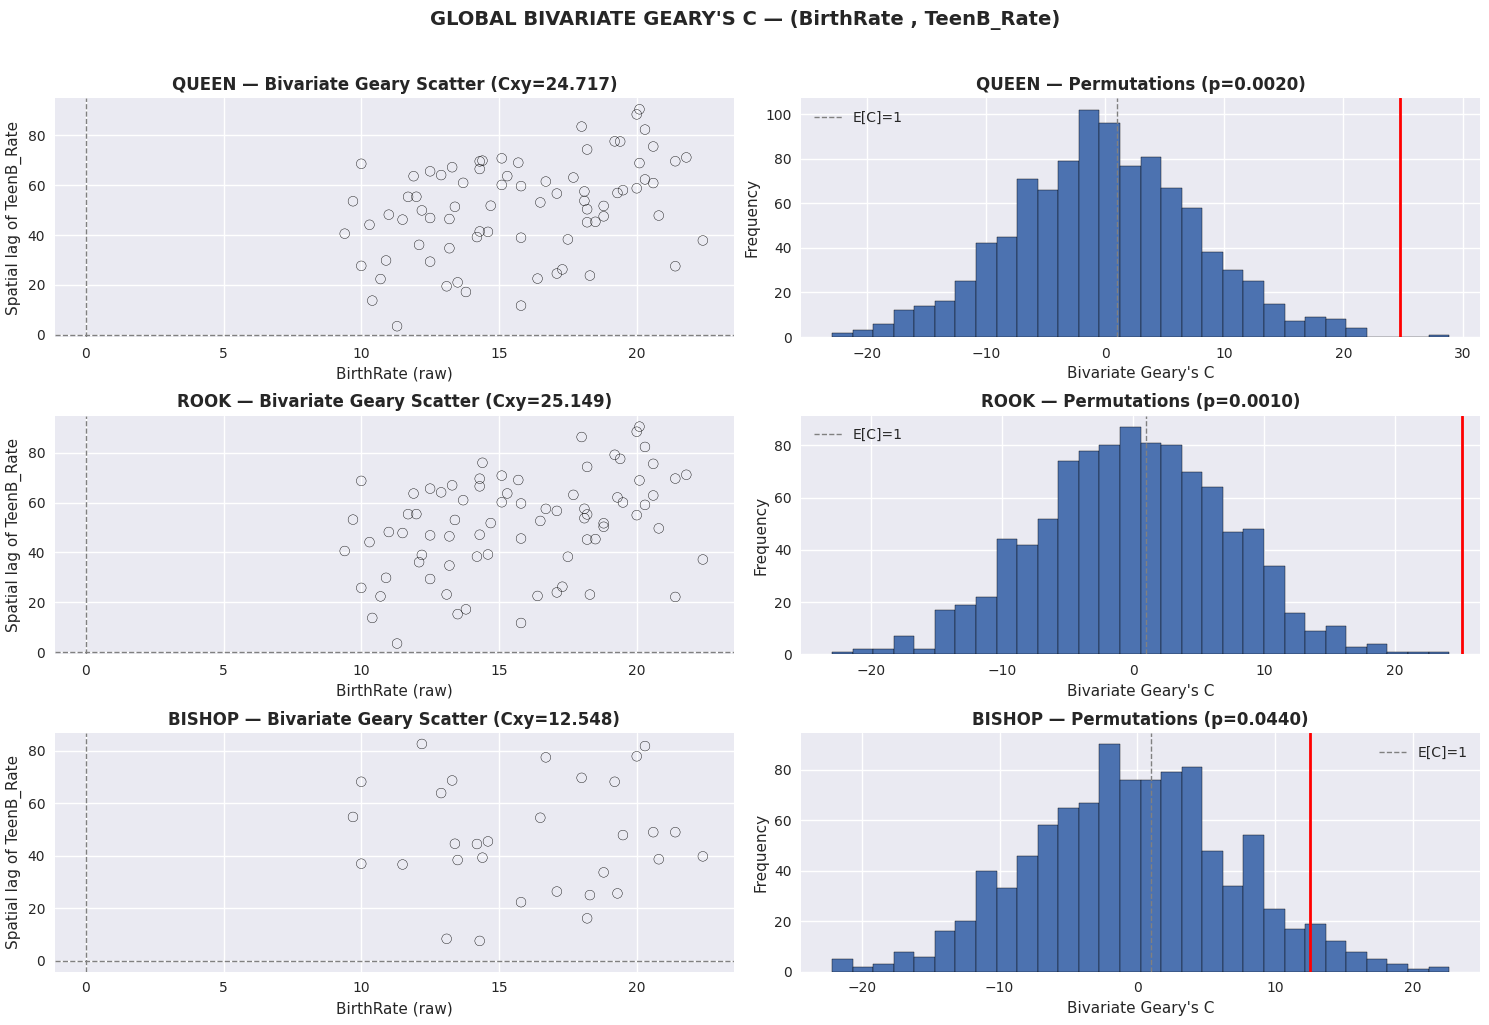

In [8]:
gdf = gpd.read_file("../Data Bases/healthindicators/HealthIndicators.shp")

tab, fig, out = global_geary_bv(
    gdf=gdf,
    x_fields=["BirthRate"],
    y_fields=["TeenB_Rate"],
    contiguities=("queen", "rook", "bishop"),
    permutations=999,
    alpha=0.05,
    standardize_xy=False,
    dashboard_pair=("BirthRate", "TeenB_Rate"),
)

display(tab)
plt.show()

---